# Fabey Perot in meep

## first of all load the library

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt


## 定義參數
$c=f\lambda$ but **f**單位($1\over\mu$) $\Rightarrow$ c=$3\times10^{14}$ $\Rightarrow$ $f_u=f\times3\times10^{14} Hz$ 

In [2]:
Nf = 1000 
fmin = 1.2 # 360THz
fmax = 1.6 # 480THz
fre = np.linspace(fmin,fmax,Nf) #在fmin fmax 間點出 Nf個點
d=0.5 #thinkness = 500nm
epsi = 12 #ε
omega = 2 * np.pi * fre

In [3]:
resolution = 100 #解析度 pixels/μm
dpml = 1.0 #吸收邊界EM wave 模擬無限大(1μ圍住cell)
sz = 16 + 2*dpml #size
cell_size = mp.Vector3(z=sz) #在z方向使用長度sz的單元格，具一定傳播距離，不影響波導模式
pml_layers = [mp.PML(dpml)] #設立dpml上述的boundary
fcen = (fmin+fmax)/2  # center frequency
df = (fmax-fmin)  # frequency width
dimensions = 1 # 維度

## Sources set up

In [4]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), 
                     component=mp.Ex,center=mp.Vector3(z=-8))]
#GaussianSource enter frequency and a frequency width
#(width of the Gaussian spectrum)

## Simulation 真空

In [5]:
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        #Courant = 0.1,
                        resolution=resolution)
#上方定義過的參數 代入 模擬真空
refl_fr = mp.FluxRegion(center=mp.Vector3(z=-8))
refl = sim_vac.add_flux(fcen, df, Nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z= 8 ))
tran = sim_vac.add_flux(fcen, df, Nf, tran_fr)
#上反射下穿透 FluxRegion建立一個 通量區域(在z=-8) add_flux在通量區域
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex,
                                                            mp.Vector3(z=0),1e-3))
#設定關閉sources後繼續運行(時間) 在相對 peak value decayed 1/1000
#在source關閉後 在Ex每50個時間單位 確認
empty_flux = mp.get_fluxes(tran)
empty_data = sim_vac.get_flux_data(refl)
#保存真空DATA 計算反透射率

-----------
Initializing structure...
time for choose_chunkdivision = 0.000117064 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
time for set_epsilon = 0.000386953 s
-----------
field decay(t = 50.005): 0.25044062863645467 / 0.25044062863645467 = 1.0
field decay(t = 100.01): 1.3591234339925318e-15 / 0.25044062863645467 = 5.426928695205707e-15
run 0 finished at t = 100.01 (20002 timesteps)


## Simulation 介質 一層

In [6]:
geometry = []
Np = 1 #number of repeating
for i in range (Np):
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d), center=mp.Vector3(z = -3 + 0.6 * i),
                     material= mp.Medium(epsilon=epsi)))
#waveguide 由一個 (無限,無限,d) 中心為z=-3 + 0.6 * i ε=epsi指定
sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        #Courant = 0.1,
                        dimensions=dimensions,
                        resolution=resolution)
#再次輸入參數 但加入geometry
tran = sim.add_flux(fcen, df, Nf, tran_fr)
refl = sim.add_flux(fcen, df, Nf, refl_fr)
sim.load_minus_flux_data(refl, empty_data)
#再次模擬通量 儲存計算反透射率
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(refl)
#存入反透射的通量 紀錄相對的頻率

wvls = np.empty(Nf)
R = np.empty(Nf)
T = np.empty(Nf)
for i in range(Nf):
        wvls[i] = 1/freqs[i]
        R[i] = -refl_flux[i]/empty_flux[i]
        T[i] = tran_flux[i]/empty_flux[i]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
     block, center = (0,0,-3)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.000412941 s
-----------
field decay(t = 50.005): 0.14625631375814824 / 0.14625631375814824 = 1.0
field decay(t = 100.01): 1.9302058896572244e-09 / 0.14625631375814824 = 1.3197419243377373e-08
run 0 finished at t = 100.01 (20002 timesteps)


## Simulation 介質 15層

In [7]:
geometry15 = []
Np = 15 #number of repeating
for i in range (Np):
    geometry15.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d), center=mp.Vector3(z = -3 + 0.6 * i),
                     material= mp.Medium(epsilon=epsi)))
#waveguide 由一個 (無限,無限,d) 中心為z=-3 + 0.6 * i ε=epsi指定
sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry15,
                        boundary_layers=pml_layers,
                        sources=sources,
                        #Courant = 0.1,
                        dimensions=dimensions,
                        resolution=resolution)
#再次輸入參數 但加入geometry
tran15 = sim.add_flux(fcen, df, Nf, tran_fr)
refl15 = sim.add_flux(fcen, df, Nf, refl_fr)
sim.load_minus_flux_data(refl15, empty_data)
#再次模擬通量 儲存計算反透射率
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

refl_flux15 = mp.get_fluxes(refl15)
tran_flux15 = mp.get_fluxes(tran15)
freqs15 = mp.get_flux_freqs(refl15)
#存入反透射的通量 紀錄相對的頻率

wvls = np.empty(Nf)
R15 = np.empty(Nf)
T15 = np.empty(Nf)
for i in range(Nf):
        wvls[i] = 1/freqs[i]
        R15[i] = -refl_flux15[i]/empty_flux[i]
        T15[i] = tran_flux15[i]/empty_flux[i]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
     block, center = (0,0,-3)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-1.8)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-1.2)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-0.6)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     bloc

## plot

/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


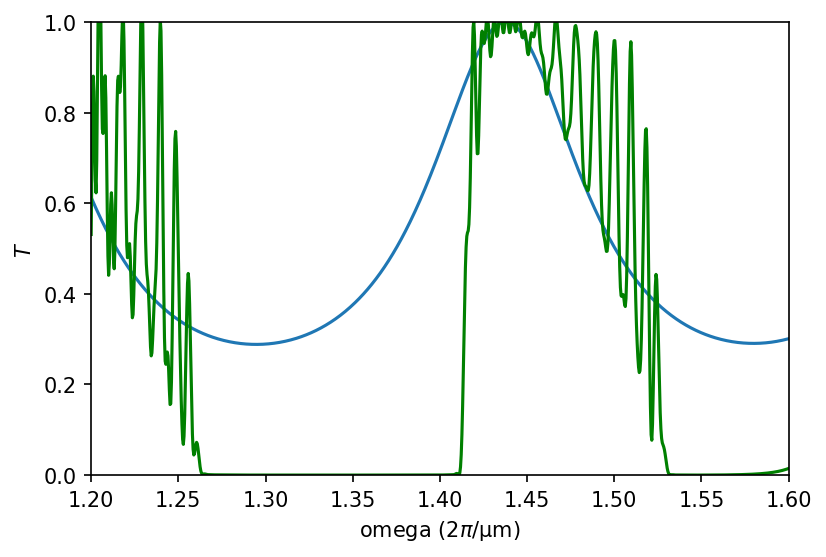

In [8]:
plt.figure(dpi=150)#解析度
plt.plot(omega/2/np.pi,T,'-',label='$T_{nur}$')#x軸omega y軸T 
plt.plot(omega/2/np.pi,T15,'g-',label='$T_{nur15}$')
plt.xlabel("omega ($2\pi$/μm)")
plt.ylabel("$T$")
plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.savefig('1and15 .png')
plt.show()